In [113]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],  # "Times", "Palatino", "New Century Schoolbook", "Bookman", 
    "axes.labelsize": 16
    })
import random
import csv
import pandas as pd
import h5py
import yt
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return

# Introduction

We can run a few simulations in Gmunu. Looking at the .dat files (output from the simulations) is a bit trickier. Hence, we load them here and postprocess/discuss/plot the data in this Python notebook.

# Smooth sine wave

Define the analytic results

In [194]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

Read in the Kastaun and neural net sine waves

In [195]:
fname = os.path.join(master_dir, "Data/kastaun_wave.dat")
kastaun_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/neuralnet_wave.dat")
neuralnet_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/mock_table_wave.dat")
mock_table_wave = yt.load(fname)
fname = os.path.join(master_dir, "Data/sanity_check.dat")
assist_wave = yt.load(fname)

# Final time of simulation 
T_final = float(kastaun_wave.current_time)
# Additional preprocessing - see Gmunu for the source of this
for wave in [kastaun_wave, neuralnet_wave, mock_table_wave, assist_wave]:
    # Add gamma and veloc1
    wave.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    wave.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
# Get the plotdata
plotdata_kastaun    = kastaun_wave.ortho_ray(0, (0, 0))
plotdata_neuralnet  = neuralnet_wave.ortho_ray(0, (0, 0))
plotdata_mock_table = mock_table_wave.ortho_ray(0, (0, 0))
plotdata_assist     = assist_wave.ortho_ray(0, (0, 0))

yt : [INFO     ] 2023-05-31 14:21:14,509 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-31 14:21:14,509 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-31 14:21:14,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 14:21:14,509 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-31 14:21:14,525 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-31 14:21:14,617 Parameters: current_time              = 2.0
yt : [INFO     ] 2023-05-31 14:21:14,617 Parameters: domain_dimensions         = [128   1   1]
yt : [INFO     ] 2023-05-31 14:21:14,625 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 14:21:14,628 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-31 14:21:14,629 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-31 14:21:14,731 Parameters: current_time              = 2.0
yt : [INFO     ] 2023

## Solutions

### Kastaun and NNC2P

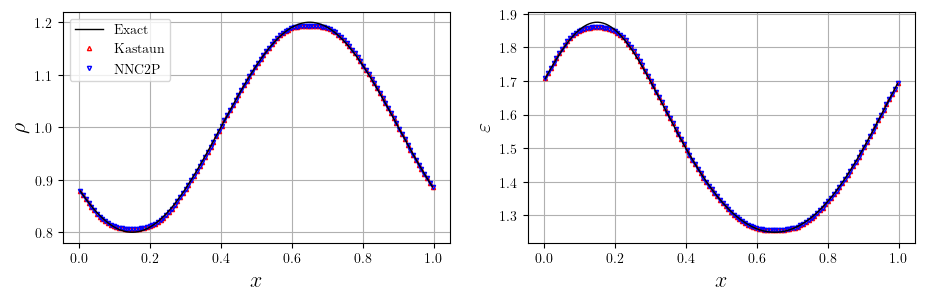

In [168]:
waves = [kastaun_wave, neuralnet_wave, mock_table_wave]
labels = ["Kastaun", "NNC2P", "Mock EOS table"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        exact_eps = (3/2) * (1/exact_vals)
        ax1.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
        ax2.plot(np.array(plotdata['x'][srt]), exact_eps, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
    # The approximation
    ax1.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), linestyle='',  color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['x'][srt]), np.array(plotdata['eps'][srt]), linestyle='', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    
# Make a nice plot
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\varepsilon$")
for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_xlabel(r"$x$")
    ax.grid()
ax1.legend()
# plt.title("Smooth sine wave test")
if limit == 2:
    plt.savefig(os.path.join(master_dir, "Plots/smooth_wave_rho_kastaun_neuralnet.pdf"), bbox_inches='tight')
else:
    plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_kastaun_neuralnet_mock.pdf"), bbox_inches='tight')
plt.show()

### NNC2P and mock EOS table

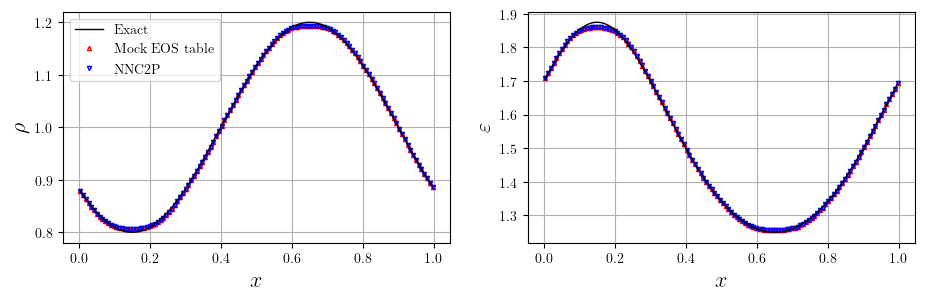

In [169]:
waves = [mock_table_wave, neuralnet_wave]
labels = ["Mock EOS table", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        exact_eps = (3/2) * (1/exact_vals)
        ax1.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
        ax2.plot(np.array(plotdata['x'][srt]), exact_eps, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
    # The approximation
    ax1.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), linestyle='',  color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['x'][srt]), np.array(plotdata['eps'][srt]), linestyle='', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    
# Make a nice plot
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\varepsilon$")
for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_xlabel(r"$x$")
    ax.grid()
ax1.legend()
plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_neuralnet_mock.pdf"), bbox_inches='tight')
plt.show()

In [170]:
print(f"{len(plotdata['x'][srt])} points in the plot")

128 points in the plot


## Differences

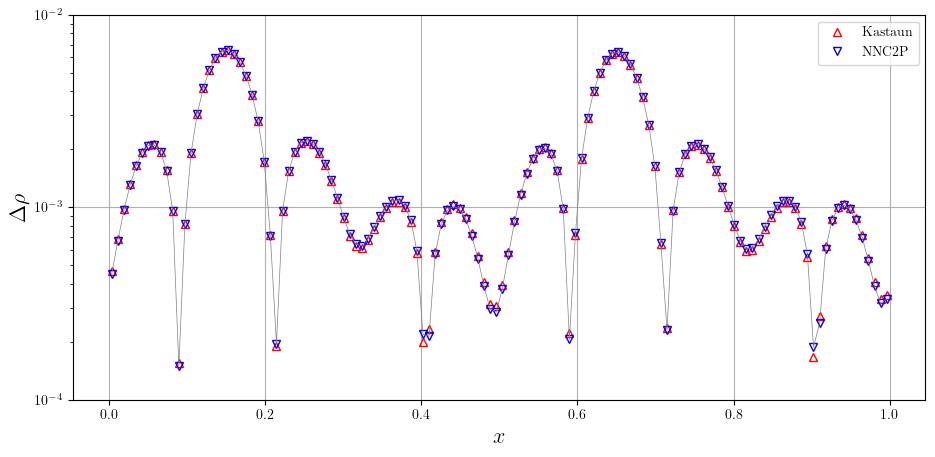

In [171]:
waves = [kastaun_wave, neuralnet_wave]
labels = ["Kastaun", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
plotstyles = ["r^", "bv", "g^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    diffs_rho = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), diffs_rho, plotstyles[i], label = labels[i], fillstyle=fillstyle, lw = lw)

# Plot the line connecting them for clarity
plt.plot(np.array(plotdata['x'][srt]), diffs_rho, "-", color="gray",lw=0.5)
# Make a nice plot
plt.ylabel(r"$\Delta\rho$")
plt.xlabel(r"$x$")
plt.yscale('log')
plt.grid()
plt.legend()
# plt.title("Smooth sine wave test")
plt.ylim(1e-4 - small_delta, 1e-2 + small_delta)
plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_kastaun_neuralnet_diffs.pdf"), bbox_inches='tight')
plt.show()

In [172]:
print(f"The relative mean difference is: {np.mean(diffs_rho)} pm {np.std(diffs_rho)}")
print(f"The lowest and highest diff  is: {np.min(diffs_rho)} , {np.max(diffs_rho)}")

The relative mean difference is: 0.0017153544245694253 pm 0.0016315979001183896
The lowest and highest diff  is: 0.00014942789295135928 , 0.006541703487670136


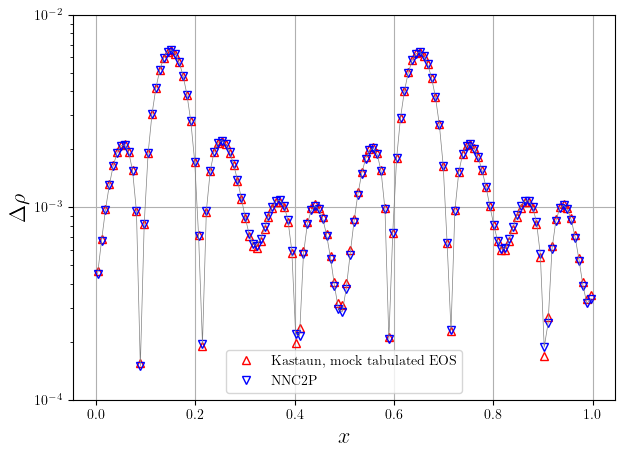

In [173]:
waves = [mock_table_wave, neuralnet_wave]
labels = ["Kastaun, mock tabulated EOS", "NNC2P"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
plotstyles = ["r^", "bv", "g^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(7,5))
for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    # Difference with numerical solution
    diffs_rho = abs(np.array(plotdata['rho'][srt]) - exact_vals)
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), diffs_rho, plotstyles[i], label = labels[i], fillstyle=fillstyle, lw = lw)

# Plot the line connecting them for clarity
plt.plot(np.array(plotdata['x'][srt]), diffs_rho, "-", color="gray",lw=0.5)
# Make a nice plot
plt.ylabel(r"$\Delta\rho$")
plt.xlabel(r"$x$")
plt.yscale('log')
plt.grid()
plt.legend()
# plt.title("Smooth sine wave test")
plt.ylim(1e-4 - small_delta, 1e-2 + small_delta)
plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_mock_neuralnet_diffs.pdf"), bbox_inches='tight')
plt.show()

## Sanity check: mock table is different from exact Kastaun

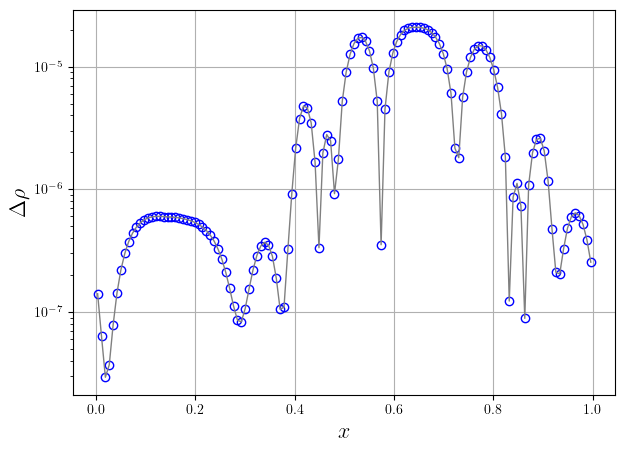

In [176]:
kastaun_check = kastaun_wave.ortho_ray(0, (0, 0))
srt = np.argsort(kastaun_check['x'])
kastaun_rho_check = np.array(kastaun_check['rho'][srt])

mock_check = mock_table_wave.ortho_ray(0, (0, 0))
srt = np.argsort(mock_check['x'])
mock_rho_check = np.array(mock_check['rho'][srt])

diffs_kastaun_mock = abs(kastaun_rho_check - mock_rho_check)

plt.figure(figsize=(7,5))
plt.plot(np.array(mock_check['x'][srt]), diffs_kastaun_mock, linestyle='', marker="o", color="blue", label=r"|Kastaun - mock EOS table|", ms=6, fillstyle="none")
plt.plot(np.array(mock_check['x'][srt]), diffs_kastaun_mock, "-", color="gray", lw=1)
plt.grid()
# plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$\Delta\rho$")
plt.yscale('log')
plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_diffs_mock_and_kastaun.pdf"), bbox_inches='tight')

plt.show()

In [177]:
print(f"Average error by mock EOS table: {np.mean(diffs_kastaun_mock)}")

Average error by mock EOS table: 4.650274456266014e-06


__TODO__ how to get other entries in the .dat file?

## Kastaun and NN assist

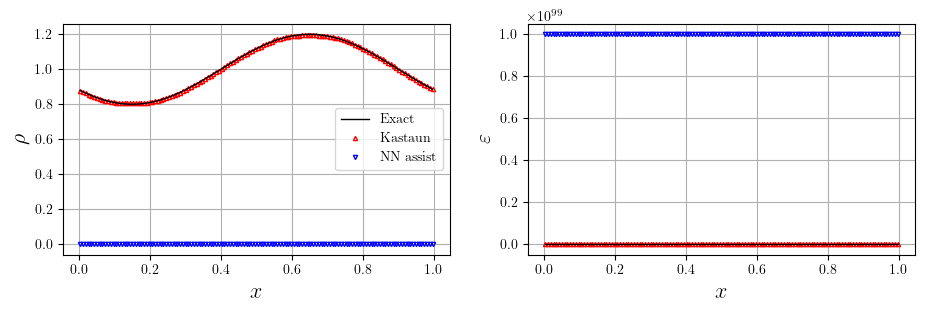

In [196]:
waves = [kastaun_wave, assist_wave]
labels = ["Kastaun", "NN assist"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, wave in enumerate(waves[:limit]):
    # cutting the x-axis through the y=0,z=0 
    plotdata = wave.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    
    # Exact values for this simulation
    if i == 0:
        exact_vals = np.array(rho_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
        exact_eps = (3/2) * (1/exact_vals)
        ax1.plot(np.array(plotdata['x'][srt]), exact_vals, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
        ax2.plot(np.array(plotdata['x'][srt]), exact_eps, '-', color="black", label="Exact", lw=lw, alpha = alpha, zorder=1000)
    # The approximation
    ax1.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]), linestyle='',  color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['x'][srt]), np.array(plotdata['eps'][srt]), linestyle='', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    
# Make a nice plot
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\varepsilon$")
for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_xlabel(r"$x$")
    ax.grid()
ax1.legend()
# plt.title("Smooth sine wave test")
if limit == 2:
    plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_kastaun_assist.pdf"), bbox_inches='tight')
else:
    plt.savefig(os.path.join(master_dir, "Plots/Final/smooth_wave_rho_kastaun_assist.pdf"), bbox_inches='tight')
plt.show()

In [181]:
# mu_wave_assist = np.loadtxt("../Data/mu_wave_assist.dat")
# mu_wave = np.loadtxt("../Data/mu_wave.dat")
# plt.boxplot([mu_wave_assist, mu_wave])
# plt.show()

In [182]:
# mu_shock_assist = np.loadtxt("../Data/mu_shock_assist.dat")
# mu_shock = np.loadtxt("../Data/mu_shock.dat")
# plt.boxplot([mu_shock_assist, mu_shock])
# plt.show()

Compare the results from nn assist = false and computing NN on the side:

In [183]:
# # Get data
# mu = np.loadtxt("../Data/mu.dat")
# mu_guess = np.loadtxt("../Data/mu_guess.dat")
# mu_left, mu_right = mu_guess[:, 0], mu_guess[:, 1]
# width = 0.01 # see Gmunu code
# mu_hat = mu_right - width
# mu_err = width


In [184]:
# plt.errorbar(mu, mu_hat, yerr = mu_err, fmt = 'o', color="blue", markersize=2, capsize=5)
# xvals = np.arange(np.min(mu), np.max(mu), 0.001)
# plt.plot(xvals, xvals, "--", color = "black")
# plt.ylim(0, np.max(mu))
# plt.savefig("../Plots/relation_")
# plt.show()

In [185]:
# plt.plot(mu, mu_hat, "o", color="blue")
# plt.plot(xvals, xvals, "--", color = "black")
# plt.show()

What about the counts?

In [186]:
# # Get data
# counts = np.loadtxt("../Data/counts_wave.dat", dtype="object")
# counts_assist = np.loadtxt("../Data/counts_wave_assist.dat", dtype="object")
# # Convert second column to float
# counts = counts[:, 1].astype(float)
# counts_assist = counts_assist[:, 1].astype(float)

In [187]:
# print(np.mean(counts))
# print(np.mean(counts_assist))

# Shocktube

In [115]:
# Load the datasets
kastaun_shock = yt.load(os.path.join(master_dir, "Data/kastaun_shock.dat"))
kastaun_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
kastaun_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

neuralnet_shock = yt.load(os.path.join(master_dir, "Data/neuralnet_shock.dat"))
neuralnet_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
neuralnet_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

mock_table_shock = yt.load(os.path.join(master_dir, "Data/mock_table_shock.dat"))
mock_table_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
mock_table_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

assist_shock = yt.load(os.path.join(master_dir, "Data/assist_shock.dat"))
assist_shock.add_field( ('amrvac','gamma'), function=gamma, sampling_type='cell')
assist_shock.add_field( ('amrvac','veloc1'), function=veloc1, sampling_type='cell')

yt : [INFO     ] 2023-05-31 13:01:24,212 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-31 13:01:24,212 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-31 13:01:24,212 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 13:01:24,212 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-31 13:01:24,228 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-31 13:01:24,251 e not found and no parfile passed, can not set thermal_pressure.
yt : [INFO     ] 2023-05-31 13:01:24,465 Parameters: current_time              = 0.4
yt : [INFO     ] 2023-05-31 13:01:24,465 Parameters: domain_dimensions         = [16  1  1]
yt : [INFO     ] 2023-05-31 13:01:24,465 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 13:01:24,465 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-31 13:01:24,465 Parameters: cosmological_simulation   = 0
yt : [

Get the data

In [116]:
# cutting the x-axis through the y=0,z=0 
plotdata_kastaun = kastaun_shock.ortho_ray( 0, (0, 0) )
plotdata_neuralnet = neuralnet_shock.ortho_ray( 0, (0, 0) )
plotdata_mock_table = mock_table_shock.ortho_ray( 0, (0, 0) )
plotdata_assist = assist_shock.ortho_ray( 0, (0, 0) )

# Sort the ray values by 'x' so there are no discontinuities in the line plot
kastaun_srt = np.argsort(plotdata_kastaun['x'])
neuralnet_srt = np.argsort(plotdata_neuralnet['x'])
mock_table_srt = np.argsort(plotdata_mock_table['x'])
assist_srt = np.argsort(plotdata_assist['x'])

keys: rho, press, veloc1

## Solutions

In [117]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

Kastaun and neuralnet comparison

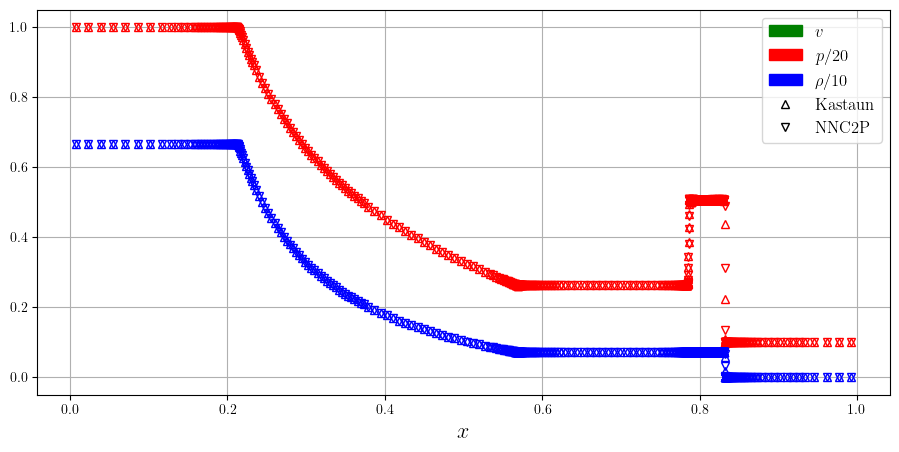

In [120]:
plotdata_list = [plotdata_kastaun, plotdata_neuralnet]
labels = ["Kastaun", "NNC2P"]
colors = ["red", "blue", "green"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, plotdata in enumerate(plotdata_list[:limit]):
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
#     if i == 0:
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), linestyle='-', color = "black", lw = lw, zorder=1000)
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), linestyle='-', color = "black", lw = lw, zorder=1000)
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), linestyle='-', color = "black", lw = lw, zorder=1000)
    # Difference with numerical solution
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), linestyle='', color = "red", marker=markers[i], fillstyle=fillstyle, lw = lw)
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), linestyle='', color = "blue", marker=markers[i], fillstyle=fillstyle, lw = lw)
#     plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), linestyle='', color = "green", marker=markers[i], fillstyle=fillstyle, lw = lw)

# Make a nice plot
plt.xlabel(r"$x$")
plt.grid()
# Nice legend:
# Define custom legend handles and labels
legend_handles = [
    mpatches.Patch(color='green'),
    mpatches.Patch(color='red'),
    mpatches.Patch(color='blue'),
    mlines.Line2D([], [], marker='^', color='black', linestyle='None', fillstyle="none"),
    mlines.Line2D([], [], marker='v', color='black', linestyle='None', fillstyle="none")
]
legend_labels = [r'$v$', r'$p/20$', r'$\rho/10$', 'Kastaun', 'NNC2P']
plt.legend(legend_handles, legend_labels, fontsize=12)
plt.savefig(os.path.join(master_dir, "Plots/Final/shocktube_rho_kastaun_neuralnet.pdf"), bbox_inches='tight')
plt.show()

Kastaun and NN assist comparison

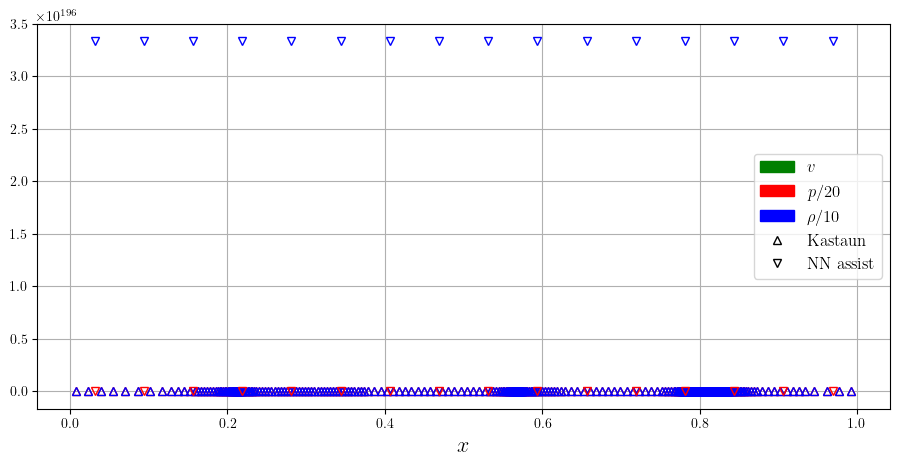

In [121]:
plotdata_list = [plotdata_kastaun, plotdata_assist]
labels = ["Kastaun", "NN assist"]
colors = ["red", "blue", "green"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1
small_delta = 0

# Limit:
# 2 -- don't plot mock EOS table
# 3 -- plot mock EOS table
limit = 2
plt.figure(figsize=(11,5))
for i, plotdata in enumerate(plotdata_list[:limit]):
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Exact values for this simulation
#     if i == 0:
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), linestyle='-', color = "black", lw = lw, zorder=1000)
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), linestyle='-', color = "black", lw = lw, zorder=1000)
#         plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), linestyle='-', color = "black", lw = lw, zorder=1000)
    # Difference with numerical solution
    # Plot them
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), linestyle='', color = "red", marker=markers[i], fillstyle=fillstyle, lw = lw)
    plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), linestyle='', color = "blue", marker=markers[i], fillstyle=fillstyle, lw = lw)
#     plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), linestyle='', color = "green", marker=markers[i], fillstyle=fillstyle, lw = lw)

# Make a nice plot
plt.xlabel(r"$x$")
plt.grid()
# Nice legend:
# Define custom legend handles and labels
legend_handles = [
    mpatches.Patch(color='green'),
    mpatches.Patch(color='red'),
    mpatches.Patch(color='blue'),
    mlines.Line2D([], [], marker='^', color='black', linestyle='None', fillstyle="none"),
    mlines.Line2D([], [], marker='v', color='black', linestyle='None', fillstyle="none")
]
legend_labels = [r'$v$', r'$p/20$', r'$\rho/10$', 'Kastaun', 'NN assist']
plt.legend(legend_handles, legend_labels, fontsize=12)
plt.savefig(os.path.join(master_dir, "Plots/Final/shocktube_rho_kastaun_assist.pdf"), bbox_inches='tight')
plt.show()

Reference:

In [19]:
# # Plot the data
# plotdata = plotdata_mock_table
# srt = np.argsort(plotdata['x'])
# plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['rho'][srt]/10), label='rho/10')
# plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['press'][srt]/20), label='P/20')
# plt.plot(np.array(plotdata['x'][srt]), np.array(plotdata['veloc1'][srt]), label='v')

# # Save the line plot
# plt.legend(loc='best')
# plt.title("Mock table")
# plt.grid()
# plt.show()

## Diffs shocktube Kastaun and mock table

In [ ]:
kastaun_check

In [43]:
print(len(kastaun_srt))
print(len(mock_srt))

528
516


In [40]:
len(mock_check['x'])

516

In [51]:
import sys

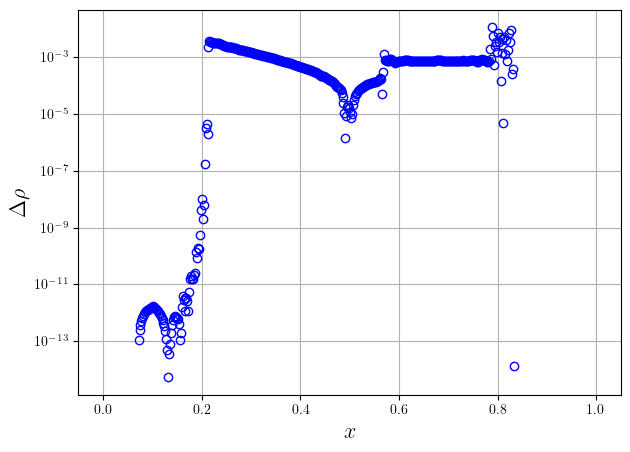

In [55]:
kastaun_check = kastaun_shock.ortho_ray(0, (0, 0))
kastaun_srt = np.argsort(kastaun_check['x'])
kastaun_rho_check = np.array(kastaun_check['rho'][kastaun_srt])
kastaun_x = kastaun_check['x'][kastaun_srt]

mock_check = mock_table_shock.ortho_ray(0, (0, 0))
mock_srt = np.argsort(mock_check['x'])
mock_rho_check = np.array(mock_check['rho'][mock_srt])
mock_x = mock_check['x'][mock_srt]

# Different lenghts, so resample:
# Determine the shorter array length
shorter_length = min(len(kastaun_rho_check), len(mock_rho_check))

# Resample the shorter array using linear interpolation
new_x = np.linspace(0, 1, shorter_length)

resampled_array1 = np.interp(new_x, kastaun_x, kastaun_rho_check)
resampled_array2 = np.interp(new_x, mock_x, mock_rho_check)

# Compute the absolute difference between the resampled arrays
diffs_kastaun_mock = np.abs(resampled_array1 - resampled_array2)
# diffs_kastaun_mock += sys.float_info.min

plt.figure(figsize=(7,5))
# plt.plot(np.array(mock_check['x'][srt]), diffs_kastaun_mock, linestyle='', marker="o", color="blue", label=r"|Kastaun - mock EOS table|", ms=6, fillstyle="none")
# plt.plot(np.array(mock_check['x'][srt]), diffs_kastaun_mock, "-", color="gray", lw=1)
# plt.plot(np.array(mock_check['x'][mock_srt]), mock_rho_check, linestyle='', marker="^", color="blue", label=r"Kastaun", ms=6, fillstyle="none")
# plt.plot(np.array(kastaun_check['x'][kastaun_srt]), kastaun_rho_check, linestyle='', marker="v", color="blue", label=r"mock EOS table", ms=6, fillstyle="none")
plt.plot(new_x, diffs_kastaun_mock, linestyle='', marker="o", color="blue", label=r"mock EOS table", ms=6, fillstyle="none")
plt.grid()
# plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$\Delta\rho$")
plt.yscale('log')
plt.savefig(os.path.join(master_dir, "Plots/Final/shock_diffs_mock_and_kastaun.pdf"), bbox_inches='tight')

plt.show()

In [56]:
print(f"{np.mean(diffs_kastaun_mock)}")

0.0006581930729580613


# Convergence plots

Directory location:

In [173]:
conv_wave_dir = os.path.join(master_dir, "Data/convergence_results/conv_wave")
conv_shock_dir = os.path.join(master_dir, "Data/convergence_results/conv_shocktube")

The grid sizes that were used:

In [174]:
grid_sizes = [100, 200, 400, 800, 1600, 3200]

## Smooth sine wave

The analytic solution to the problem:

TODO - get the neural net error on the prims for a very large sample?

In [175]:
A = 0.2
v0 = 0.2
theta = 0.0

def rho_sol_pt(x,y,t):
    return 1.0 + A * np.sin(2.0 * np.pi * ( ( x * np.cos(theta) + y * np.sin(theta) ) - ( v0 * np.cos(theta) ) * t ) )

rho_sol = np.vectorize(rho_sol_pt)

def gamma(field, data):
    return  np.sqrt( 1.0 + (data['W_vel1']**2) )
def veloc1(field, data):
    return data['W_vel1'] / data['gamma']

Auxiliary method to find the numerical error from a simulation file

In [176]:
def get_all_errors(dat, grid_sizes, var_names = ["rho", "eps", "press", "veloc1"], exact_sol = rho_sol, T_final=5.0, which="sine"):
    """
    Returns a list of errors for different grids
    
    Dat: list of loaded data files to get the values of simulations from.
    """
    # Initialize empty dicts:
    # each dict: key for the var names, every value has errors for increasing grid size
    l1_dict = {}
    linfty_dict = {}
    for var in var_names:
        l1_dict[var] = []
        linfty_dict[var] = []
    
    # Iterate over each var name
    for i, grid_size in enumerate(grid_sizes):
        this_grid_data = dat[i]
        for var in var_names:
            if which == "shocktube":
                print("Not implemented")
                return l1_dict, linfty_dict
            else:
                l1, linfty = compute_error_sine(this_grid_data, var_name=var, exact_sol=exact_sol, T_final=T_final)
                l1_dict[var].append(l1)
                linfty_dict[var].append(linfty)
    return l1_dict, linfty_dict

def compute_error_sine(dat, var_name = "rho", exact_sol = rho_sol, T_final=5.0):
    """Computes error based on the exact sine wave"""
    # Get the plotdata
    plotdata   = dat.ortho_ray(0, (0, 0))
    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['x'])
    # Get exact values and numerical solution values
    rho_vals = np.array(exact_sol(np.array(plotdata['x'][srt]), 0.0, T_final))
    if var_name == "rho":
        exact_vals = rho_vals
    elif var_name == "veloc1":
        exact_vals = v0
    elif var_name == "press":
        exact_vals = 1
    elif var_name == "eps":
        exact_vals = (3/2) * (1/rho_vals)
    else:
        print("Not recognized")
        return 0, 0
    num_vals = np.array(plotdata[var_name][srt])
    # Get the differences
    diffs = abs(num_vals - exact_vals)
    
    # Append errors
    #l1 = np.mean(diffs)  # replaced by delta_N!
    l1 = np.sum(diffs)/np.sum(abs(exact_vals))
    # ^ this is delta_N, defined in Gmunu parallel, grid-adaptive,... paper!!!
    linfty = np.max(diffs)
    
    return l1, linfty

Read in the Kastaun and neural net sine waves

In [204]:
kastaun_data = []
neuralnet_data = []
for grid_size in grid_sizes:
    # Kastaun:
    fname = os.path.join(conv_wave_dir, f"kastaun_{grid_size}.dat")
    dat = yt.load(fname)
    dat.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    dat.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
    kastaun_data.append(dat)
    # Neuralnet:
    fname = os.path.join(conv_wave_dir, f"neuralnet_{grid_size}.dat")
    dat = yt.load(fname)
    dat.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    dat.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
    neuralnet_data.append(dat)

yt : [INFO     ] 2023-05-25 17:00:27,320 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-25 17:00:27,322 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-25 17:00:27,325 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 17:00:27,326 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 17:00:27,327 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-25 17:00:27,350 e not found and no parfile passed, can not set thermal_pressure.
yt : [INFO     ] 2023-05-25 17:00:27,734 Parameters: current_time              = 5.0
yt : [INFO     ] 2023-05-25 17:00:27,735 Parameters: domain_dimensions         = [100   1   1]
yt : [INFO     ] 2023-05-25 17:00:27,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-25 17:00:27,756 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-05-25 17:00:27,757 Parameters: cosmological_simulation   = 0


Compute the errors and convergence rates

In [205]:
kastaun_l1, kastaun_linfty = get_all_errors(kastaun_data, grid_sizes)
neuralnet_l1, neuralnet_linfty = get_all_errors(neuralnet_data, grid_sizes)

yt : [WARNING  ] 2023-05-25 17:00:33,648 Field ('amrvac', 'gamma') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,650 Field ('amrvac', 'veloc1') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,689 Field ('amrvac', 'gamma') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,690 Field ('amrvac', 'veloc1') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,767 Field ('amrvac', 'gamma') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,769 Field ('amrvac', 'veloc1') was added without specifying units or dimensions, auto setting units to dimensionless
yt : [WARNING  ] 2023-05-25 17:00:33,921 Field ('amrvac', 'gamma') was added wi

In [208]:
kastaun_l1

{'rho': [0.00655815126601933,
  0.0018072405985626904,
  0.000494932394563152,
  0.00013528772590231663,
  3.594577576439384e-05,
  9.395738620550133e-06],
 'eps': [0.006955360618438373,
  0.0019434348522395332,
  0.0005342318163101429,
  0.00014635328930475618,
  3.895954694148686e-05,
  1.0197186456877594e-05],
 'press': [7.907896559800065e-12,
  3.1102231901058985e-11,
  1.2822798378664402e-10,
  2.4350144123275186e-10,
  5.161417959698156e-10,
  1.8488390818305334e-09],
 'veloc1': [3.5790814756353484e-13,
  5.315192730392937e-13,
  2.143563104795021e-12,
  6.210892911084898e-11,
  4.02418098843782e-10,
  1.6155617121871302e-09]}

In [209]:
convergence_rates = []
for data in [kastaun_l1, neuralnet_l1]:
    rates = []
    for i in range(1, len(grid_sizes)):
        value = np.log2(data["rho"][i-1]/data["rho"][i])
        rates.append(value)
    convergence_rates.append(rates)

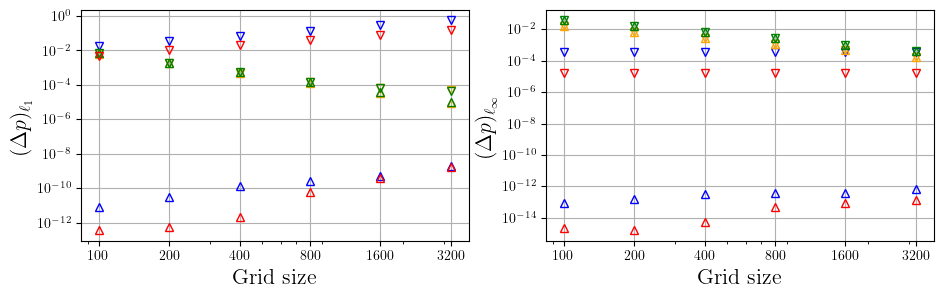

In [210]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11,3))
alph=1
ax1, ax2 = axs
color_dict = {"press": "blue", "rho": "orange", "eps": "green", "veloc1": "red"}
markers = ["^", "v"] # kastaun, neuralnet

l1_values = [kastaun_l1, neuralnet_l1]
linfty_values = [kastaun_linfty, neuralnet_linfty]

for var in color_dict.keys():
    for i in range(len(l1_values)):
        # L1 rate
        ax1.plot(grid_sizes, l1_values[i][var], linestyle='', marker=markers[i], color = color_dict[var], alpha=alph, fillstyle="none")
        ax1.set_ylabel(r"$(\Delta p)_{\ell_1}$")
        
        ax2.plot(grid_sizes, linfty_values[i][var], linestyle='', marker=markers[i], color = color_dict[var], alpha=alph, fillstyle="none")
        ax2.set_ylabel(r"$(\Delta p)_{\ell_\infty}$")

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Grid size")
    ax.set_xticks(grid_sizes, labels=grid_sizes)
    ax.grid()
#     ax.legend()
# plt.savefig(os.path.join(master_dir, "Plots/Final_plots/convergence_runs_wave.pdf"), bbox_inches='tight')
plt.show()

### Compare convergence rates (uses rho only)!

Convergence rate: see Gmunu paper ("parallel, grid adaptive,...")

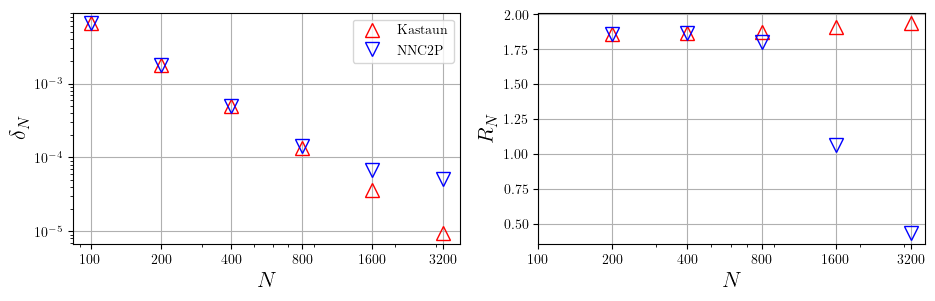

In [212]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11,3))
alph=1
ms = 10
ax1, ax2 = axs
color_dict = {"press": "blue", "rho": "orange", "eps": "green", "veloc1": "red"}
markers = ["^", "v"] # kastaun, neuralnet
labels = ["Kastaun", "NNC2P"]

l1_values = [kastaun_l1, neuralnet_l1]
linfty_values = [kastaun_linfty, neuralnet_linfty]

for i in range(len(l1_values)):
    # delta N
    ax1.plot(grid_sizes, l1_values[i]["rho"], linestyle='', marker=markers[i], ms=ms, color = colors[i], label=labels[i], alpha=alph, fillstyle="none")
    ax1.set_ylabel(r"$\delta_N$")
    # Line for ideal scaling
#     if i == 0:
#         line_x = np.arange(grid_sizes[0], grid_sizes[-1], 0.01)
#         y0 = 0.000001
#         line_y = y0 + (line_x - grid_sizes[0])**(-2)
#         ax1.plot(line_x, line_y, "--", color="black")

    # R_N
    ax2.plot(grid_sizes[1:], convergence_rates[i], linestyle='', marker=markers[i], ms=ms, color = colors[i], alpha=alph, fillstyle="none")
    ax2.set_ylabel(r"$R_N$")

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlabel(r"$N$")
    ax.set_xticks(grid_sizes, labels=grid_sizes)
    ax.grid()
ax1.legend()
ax1.set_yscale('log')
plt.savefig("../Plots/Final/convergence_runs_wave.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# alph=1
# markers = ["^", "v"] # kastaun, neuralnet
# colors = ["red", "blue"]
# labels = ["Kastaun", "NNC2P"]

# l1_values = [kastaun_l1, neuralnet_l1]

# for i in range(len(l1_values)):
#     # L1 rate
#     plt.plot(grid_sizes, l1_values[i]["rho"], linestyle='', marker=markers[i], color = colors[i], label=labels[i], alpha=alph, fillstyle="none")

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Grid size $N$")
# plt.ylabel(r"$\delta_N$")
# plt.xticks(grid_sizes, labels=grid_sizes)
# plt.grid()
# plt.legend()
# # plt.savefig(os.path.join(master_dir, "Plots/Final_plots/convergence_runs_wave.pdf"), bbox_inches='tight')
# plt.show()

## Shocktube

# Timings

In [70]:
def get_average_timing(timings):
    # Roll, get next in position of current
    rolled = np.roll(timings, -1)
    # Difference is nb of iterations per sec:
    its = rolled - wave_timings_neuralnet
    # Drop final column
    its = its[:, 0:-1]
    return np.mean(its)


Neuralnet:

In [71]:
wave_timings_neuralnet = np.array([[0, 44, 98, 151, 204], [0, 53, 106, 159, 212], [0, 53, 106, 158, 210], [0, 53, 106, 159, 212], [0, 53, 107, 160, 213], [0, 53, 106, 159, 212]])
speed_neuralnet = get_average_timing(wave_timings_neuralnet)
print(f"For neuralnet: {speed_neuralnet}")

For neuralnet: 52.625


Kastaun: computed differently since this completes in less than a second:

In [72]:
wave_timings_kastaun = np.array([0.102, 0.101, 0.103, 0.102, 0.101, 0.100])
speed_kastaun = np.mean(260/wave_timings_kastaun)
print(f"For Kastaun: {speed_kastaun}")

For Kastaun: 2561.8043186386026


Mock analytic EOS table: same

In [73]:
wave_timings_mock = np.array([251, 230, 266, 257, 40, 177, 240, 189, 176, 273, 252, 271])
speed_mock = np.mean(wave_timings_mock)
print(f"For mock: {speed_mock}")

For mock: 218.5


NN assist: same

In [75]:
wave_timings_assist = np.array([0.104, 0.097, 0.099, 0.096, 0.097, 0.103, 0.098, 0.098, 0.096, 0.097])
speed_assist = np.mean(312/wave_timings_assist)
print(f"For Kastaun: {speed_assist}")

For Kastaun: 3169.7472839965367


In [83]:
my_dict = {"Method": ["Kastaun", "Neuralnet", "Mock table", "Assist"], 
           "Speed (it/s)": np.round([speed_kastaun, speed_neuralnet, speed_mock, speed_assist], 2)}

In [86]:
df = pd.DataFrame.from_dict(my_dict)
df.sort_values(by = "Speed (it/s)", ascending=False)

,Method,Speed (it/s)
3,Assist,3169.75
0,Kastaun,3074.17
2,Mock table,218.50
1,Neuralnet,52.62


## Final results and ratios:

In [79]:
print(f"Kastaun is faster than neuralnet by a factor: {speed_kastaun/speed_neuralnet}")
print(f"Kastaun is faster than mock      by a factor: {speed_kastaun/speed_mock}")
print(f"Mock is faster than neuralnet    by a factor: {speed_mock/speed_neuralnet}")
print(f"Assist is faster than Kastaun    by a factor: {speed_assist/speed_kastaun}")
print(f"Assist is faster than mock       by a factor: {speed_assist/speed_mock}")

Kastaun is faster than neuralnet by a factor: 58.41644052002515
Kastaun is faster than mock      by a factor: 14.069405868953424
Mock is faster than neuralnet    by a factor: 4.1520190023752965
Assist is faster than Kastaun    by a factor: 1.031092051324529
Assist is faster than mock       by a factor: 14.506852558336552


Arthur sent:

In [9]:
print(3900/100)
print(3900/364)
print(364/100)

39.0
10.714285714285714
3.64


# NS simulation

In [20]:
# fname = os.path.normpath(os.path.join(master_dir, "/Data/NS simulations/nntabeos/output0004.dat"))
fname = os.path.abspath("D:/Coding/master-thesis-AI/Data/NS simulations/nntabeos/output0004.dat")
nneos = yt.load(fname)
fname = "D:/Coding/master-thesis-AI/Data/NS simulations/LT eos/output0004.dat"
# fname = os.path.normpath(os.path.join(master_dir, "Data/NS simulations/LT tabeos/output00004.dat"))
tabeos = yt.load(fname)

# Final time of simulation 
T_final = float(nneos.current_time)
# Additional preprocessing - see Gmunu for the source of this
for sol in [nneos, tabeos]:
    # Add gamma and veloc1
    sol.add_field(('amrvac','gamma'),  function=gamma,  sampling_type='cell')
    sol.add_field(('amrvac','veloc1'), function=veloc1, sampling_type='cell')
# Get the plotdata
plotdata_nneos  = nneos.ortho_ray(0, (0, 0))
plotdata_tabeos = tabeos.ortho_ray(0, (0, 0))


yt : [INFO     ] 2023-05-31 07:51:59,473 Parameters: current_time              = 812.5774454205114
yt : [INFO     ] 2023-05-31 07:51:59,475 Parameters: domain_dimensions         = [256   1   1]
yt : [INFO     ] 2023-05-31 07:51:59,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 07:51:59,479 Parameters: domain_right_edge         = [400.   1.   1.]
yt : [INFO     ] 2023-05-31 07:51:59,482 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-05-31 07:51:59,675 Parameters: current_time              = 813.1483035457605
yt : [INFO     ] 2023-05-31 07:51:59,675 Parameters: domain_dimensions         = [256   1   1]
yt : [INFO     ] 2023-05-31 07:51:59,675 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-05-31 07:51:59,682 Parameters: domain_right_edge         = [400.   1.   1.]
yt : [INFO     ] 2023-05-31 07:51:59,686 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2023-05-31 07:51:59,710 e not found and no parfil

Prepare for the plot:

In [29]:
srt = np.argsort(plotdata['r'])
length_gf = 6.77140812e-06*1.0e5 # to km
rho_gf = 1.61930347e-18
press_gf = 1.80171810e-39
eps_gf = 1.11265006e-21

x_min = plotdata['r'][0]/length_gf
x_max = plotdata['r'][-1]/length_gf

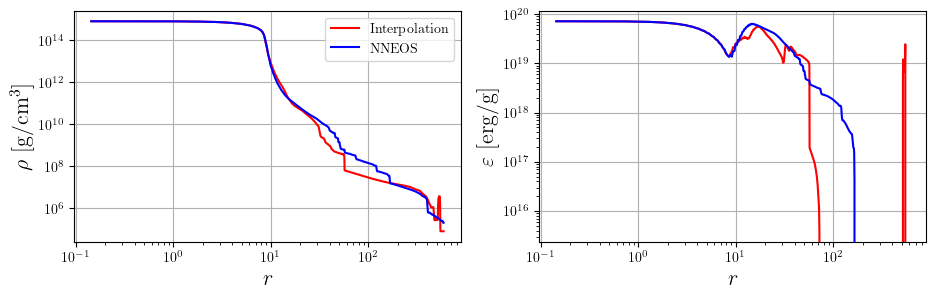

In [58]:
solutions = [nneos, tabeos]
labels = ["Interpolation", "NNEOS"]
colors = ["red", "blue", "purple"]
markers = ["^", "v", "^"]
fillstyle = "none"
ms=3
lw=1
alpha = 1

fig, axs = plt.subplots(1, 2, figsize=(11,3))
(ax1, ax2) = axs

for i, solution in enumerate(solutions):
    # cutting the x-axis through the y=0,z=0 
    plotdata = solution.ortho_ray(0, (0, 0))

    # Sort the ray values by 'x' so there are no discontinuities in the line plot
    srt = np.argsort(plotdata['r'])
    
    ax1.plot(np.array(plotdata['r'][srt])/length_gf, np.array(plotdata['rho'][srt])/rho_gf, linestyle='-', color=colors[i], fillstyle=fillstyle, ms = ms, label=labels[i])
    ax2.plot(np.array(plotdata['r'][srt])/length_gf, np.array(plotdata['eps'][srt])/eps_gf, linestyle='-', color=colors[i], fillstyle=fillstyle, ms = ms, label=labels[i]) 

    # Make a nice plot
ax1.set_ylabel(r"$\rho \ \rm{[ g / cm^3 ]}$ ")
ax2.set_ylabel(r"$\varepsilon \ [\rm{erg} / \rm{g} ]$")
for ax in axs:
    ax.set_xlabel(r"$r$")
    ax.set_xlabel(r"$r$")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
ax1.legend()
plt.savefig("../Plots/Final/NNEOS_20_20_relu_NS.pdf", bbox_inches = 'tight')
plt.show()

Look at the diffs

In [49]:
# solutions = [nneos, tabeos]
# labels = ["Interpolation", "NNEOS"]
# colors = ["red", "blue", "purple"]
# markers = ["^", "v", "^"]
# fillstyle = "none"
# ms=3
# lw=1
# alpha = 1

# fig, axs = plt.subplots(1, 2, figsize=(11,3))
# (ax1, ax2) = axs

# # Sort the ray values by 'x' so there are no discontinuities in the line plot
# srt = np.argsort(plotdata['r'])

# diffs_press = abs(np.array(plotdata_nneos['rho'][srt]) - np.array(plotdata_tabeos['rho'][srt]))
# diffs_eps = abs(np.array(plotdata_nneos['eps'][srt]) - np.array(plotdata_tabeos['eps'][srt]))

# ax1.plot(np.array(plotdata['r'][srt])/length_gf, diffs_press, linestyle='-', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i])
# ax2.plot(np.array(plotdata['r'][srt])/length_gf, diffs_eps, linestyle='-', color=colors[i], marker=markers[i], fillstyle=fillstyle, ms = ms, label=labels[i]) 

#     # Make a nice plot
# # ax1.set_ylabel(r"$\rho \\rm{[ g / cm^3 ]}$ ")
# # ax2.set_ylabel(r"$\varepsilon$")
# for ax in axs:
#     ax.set_xlabel(r"$x$")
#     ax.set_xlabel(r"$x$")
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.grid()
# ax1.legend()
# plt.show()

Look at differences?

In [59]:
# fname = os.path.normpath(os.path.join(master_dir, "/Data/NS simulations/nntabeos/output0004.dat"))
fname = os.path.abspath("D:/Coding/master-thesis-AI/Data/NS simulations/nntabeos/comparison_prs.dat")
comparison_prs = np.loadtxt(fname)
comparison_prs.shape

(538685, 3)

# GRMHD